In [1]:
import os
import numpy as np
import rasterio as ras
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [2]:
input_dop_folder = "Z:/BuildingDetection/dop_Normalized"
output_dop_folder = "Z:/BuildingDetection/dop_Resample"

os.makedirs(output_dop_folder, exist_ok=True)  # Ensure the output folder exists

In [3]:
# Get a sorted list of .tif files in the folder
all_files = [f for f in os.listdir(input_dop_folder ) if f.endswith((".tif", ".tiff"))]

# Select the first 4 files (or a specific slice)
files_to_check = all_files[0:8]

# Loop through the selected files and display their resolutions
for filename in files_to_check:
    file_path = os.path.join(input_dop_folder, filename)
    
    # Open the file and extract resolution
    with ras.open(file_path) as src:
        resolution = src.res  # Get resolution (pixel size in x and y)
        
        print(f"File: {filename} - Resolution (X, Y): {resolution}")

File: dop10rgbi_32_280_5652_1_nw_2023.tiff - Resolution (X, Y): (1.2120309925343696e-06, 1.2120309925343696e-06)
File: dop10rgbi_32_280_5653_1_nw_2023.tiff - Resolution (X, Y): (1.2122123451432434e-06, 1.2122123451432434e-06)
File: dop10rgbi_32_280_5654_1_nw_2023.tiff - Resolution (X, Y): (1.2123938054702002e-06, 1.2123938054702002e-06)
File: dop10rgbi_32_280_5655_1_nw_2023.tiff - Resolution (X, Y): (1.2125753735960162e-06, 1.2125753735960162e-06)
File: dop10rgbi_32_280_5656_1_nw_2023.tiff - Resolution (X, Y): (1.212757049600186e-06, 1.212757049600186e-06)
File: dop10rgbi_32_280_5657_1_nw_2023.tiff - Resolution (X, Y): (1.2129388335633479e-06, 1.2129388335633479e-06)
File: dop10rgbi_32_280_5658_1_nw_2023.tiff - Resolution (X, Y): (1.2131207255659931e-06, 1.2131207255659931e-06)
File: dop10rgbi_32_280_5659_1_nw_2023.tiff - Resolution (X, Y): (1.2133027256874904e-06, 1.2133027256874904e-06)


In [4]:
# Target CRS and resolution
target_crs = "EPSG:32632"  # Example: UTM Zone 32N 
target_resolution = 0.5  # 0.5 meters per pixel

In [5]:

# Process each file
for filename in all_files:
    input_path = os.path.join(input_dop_folder, filename)
    output_path = os.path.join(output_dop_folder, filename)

    with ras.open(input_path) as src:
        # Debug input metadata
        print(f"Processing file: {input_path}")
        print(f"Input resolution (X, Y): {src.res}, CRS: {src.crs}")

        # Calculate new transform and dimensions for target resolution
        transform, width, height = calculate_default_transform(
            src.crs, target_crs,  # Reproject to target CRS
            src.width, src.height, *src.bounds,
            resolution=(target_resolution, target_resolution)
        )
        print(f"New dimensions (width x height): {width} x {height}")

        # Update metadata for the new file
        new_meta = src.meta.copy()
        new_meta.update({
            "crs": target_crs,
            "transform": transform,
            "width": width,
            "height": height,
            "compress": "lzw"  # Optional: Apply LZW compression to reduce file size
        })

        # Create the output file with resampled data  
        with ras.open(output_path, "w", **new_meta) as dst:
            for band in range(1, src.count + 1):  # Process each band
                # Create an empty destination array for the resampled data
                destination = np.empty((height, width), dtype=src.dtypes[0])

                # Resample using bilinear interpolation
                reproject(
                    source=ras.band(src, band),
                    destination=destination,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.bilinear  # Use Resampling.nearest for categorical data
                )

                # Write the resampled band to the output file
                dst.write(destination, band)

    print(f"Resampled and saved: {output_path}")

print("Resampling to 0.5m resolution complete!")


Processing file: Z:/BuildingDetection/dop_Normalized\dop10rgbi_32_280_5652_1_nw_2023.tiff
Input resolution (X, Y): (1.2120309925343696e-06, 1.2120309925343696e-06), CRS: EPSG:4326
New dimensions (width x height): 2170 x 2170
Resampled and saved: Z:/BuildingDetection/dop_Resample\dop10rgbi_32_280_5652_1_nw_2023.tiff
Processing file: Z:/BuildingDetection/dop_Normalized\dop10rgbi_32_280_5653_1_nw_2023.tiff
Input resolution (X, Y): (1.2122123451432434e-06, 1.2122123451432434e-06), CRS: EPSG:4326
New dimensions (width x height): 2170 x 2170
Resampled and saved: Z:/BuildingDetection/dop_Resample\dop10rgbi_32_280_5653_1_nw_2023.tiff
Processing file: Z:/BuildingDetection/dop_Normalized\dop10rgbi_32_280_5654_1_nw_2023.tiff
Input resolution (X, Y): (1.2123938054702002e-06, 1.2123938054702002e-06), CRS: EPSG:4326
New dimensions (width x height): 2170 x 2170
Resampled and saved: Z:/BuildingDetection/dop_Resample\dop10rgbi_32_280_5654_1_nw_2023.tiff
Processing file: Z:/BuildingDetection/dop_Normali

In [6]:
file_path = "Z:/BuildingDetection/dop_Resample/dop10rgbi_32_280_5660_1_nw_2023.tiff"

with ras.open(file_path) as src:
    print(f"File CRS: {src.crs}")
    print(f"Resolution: {src.res}")
    print(f"Width: {src.width}, Height: {src.height}")
    print(f"Number of Bands: {src.count}")
    
    for band in range(1, src.count + 1):
        data = src.read(band)
        print(f"Band {band} - Min: {data.min()}, Max: {data.max()}, Mean: {data.mean()}")

File CRS: EPSG:32632
Resolution: (0.5, 0.5)
Width: 2170, Height: 2170
Number of Bands: 4
Band 1 - Min: 0.0, Max: 0.9745725393295288, Mean: 0.2743593752384186
Band 2 - Min: 0.0, Max: 0.9765855073928833, Mean: 0.2819640338420868
Band 3 - Min: 0.0, Max: 0.9786681532859802, Mean: 0.24272550642490387
Band 4 - Min: 0.0, Max: 0.9743354320526123, Mean: 0.5650383234024048


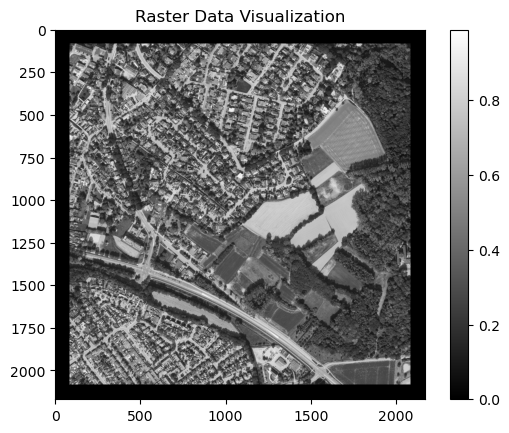

In [10]:
import matplotlib.pyplot as plt

file_resampled = "Z:/BuildingDetection/dop_Resample/dop10rgbi_32_280_5652_1_nw_2023.tiff"

with ras.open(file_resampled) as src:
    data = src.read(1)  # Read the first band
    plt.imshow(data, cmap="gray")
    plt.colorbar()
    plt.title("Raster Data Visualization")
    plt.show()


In [9]:
with ras.open(file_path) as src:
    print(f"Metadata: {src.meta}")


Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2170, 'height': 2170, 'count': 4, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]'), 'transform': Affine(0.5, 0.0, 279957.41979598807,
       0.0, -0.5, 5661042.4878888205)}


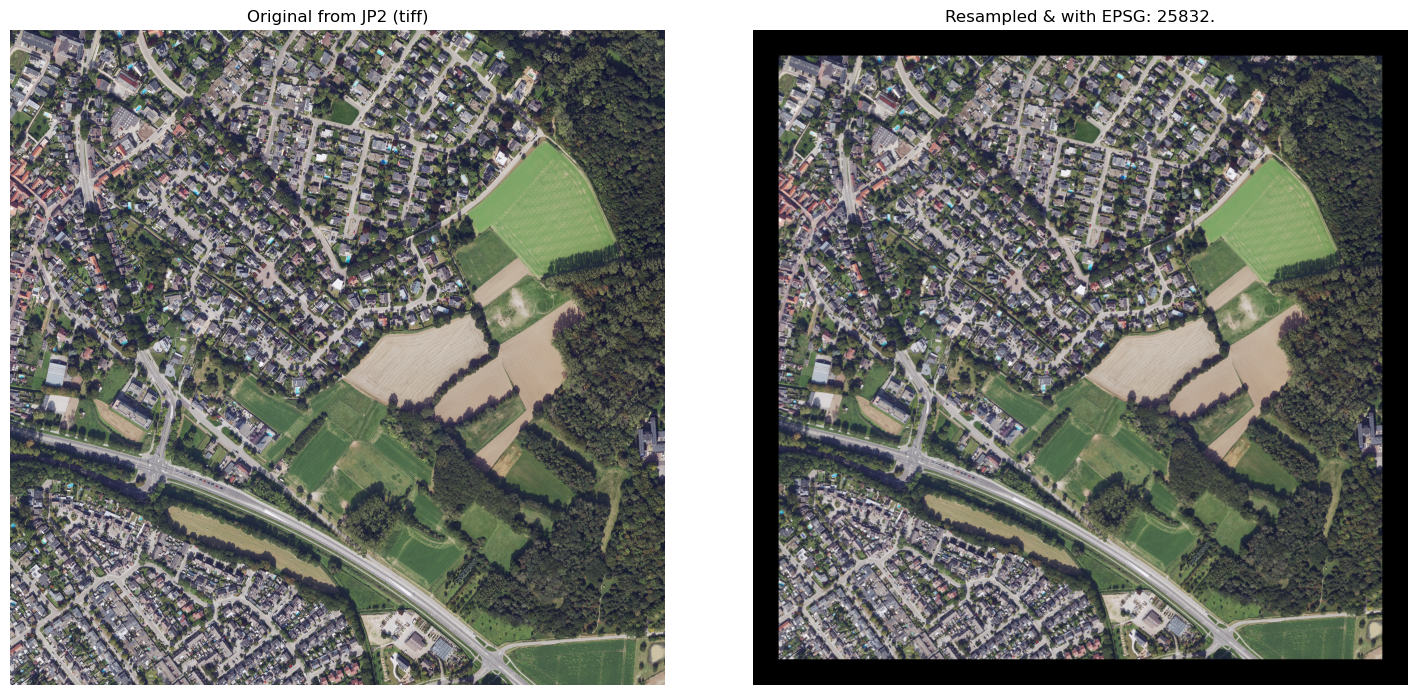

In [13]:
import matplotlib.pyplot as plt
import rasterio as ras
import numpy as np

# Define file paths
file_resampled = "Z:/BuildingDetection/dop_Resample/dop10rgbi_32_280_5652_1_nw_2023.tiff"
file_not_resampled = "Z:/BuildingDetection/dopJP2_to_tiff_2/dop10rgbi_32_280_5652_1_nw_2023.tiff"

# Function to read RGB bands from a raster
def read_rgb(file_path):
    with ras.open(file_path) as src:
        # Read the first three bands (assumes RGB in bands 1, 2, 3)
        red = src.read(1) if src.count >= 1 else None
        green = src.read(2) if src.count >= 2 else None
        blue = src.read(3) if src.count >= 3 else None
        rgb = np.stack([red, green, blue], axis=-1) if red is not None else None
    return rgb

# Read RGB data from both files
rgb_not_resampled = read_rgb(file_not_resampled)
rgb_resampled = read_rgb(file_resampled)

# Create side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Original (not resampled)
if rgb_not_resampled is not None:
    axes[0].imshow(rgb_not_resampled)
    axes[0].set_title("Original from JP2 (tiff)")
else:
    axes[0].text(0.5, 0.5, "No RGB Data", ha="center", va="center")
axes[0].axis("off")

# Resampled
if rgb_resampled is not None:
    axes[1].imshow(rgb_resampled)
    axes[1].set_title("Resampled & with EPSG: 25832.")
else:
    axes[1].text(0.5, 0.5, "No RGB Data", ha="center", va="center")
axes[1].axis("off")

plt.tight_layout()
plt.show()
